In [1]:
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
features_dir = "/home/evos/Outputs/CRC/FF/1_extract_histopathological_features/features.txt"
features_histo = pd.read_csv(features_dir, sep="\t")

In [ ]:
features_orion_dir = "/home/evos/Outputs/CRC/Orion/1_extract_histopathological_features_gamma/features.txt"
features_orion = pd.read_csv(features_orion_dir, sep="\t")
features_orion['slide_submitter_id'] = features_orion['tile_ID'].str.rsplit("-registered", n=1).str[0] + "-registered"
print(len(features_orion['slide_submitter_id'].unique()))

41


In [4]:
cell_type = 'EpiT' #'EpiT'

features_= features_histo.copy()
unique_slides = features_['slide_submitter_id'].nunique() #277
print(unique_slides)
features_filtered = features_[features_['slide_submitter_id'].isin(features_['slide_submitter_id'].unique()[:277])] 

output_path = "/home/evos/Outputs/CRC/deconvolution_sc/final_sc_deconv_results/ann1"
rectangle_estimation_ =  pd.read_csv(f"{output_path}/cell_frac_ann1.csv", sep=",", index_col=0)
rectangle_estimation = rectangle_estimation_.where(rectangle_estimation_ >= 0, 0)
print(rectangle_estimation.columns)

scaling = False 

if scaling == True:
    minmax_scaler = MinMaxScaler()
    cell_type_column = rectangle_estimation[cell_type].values.reshape(-1, 1)
    scaled_column = minmax_scaler.fit_transform(cell_type_column)
    rectangle_estimation_normalized = rectangle_estimation.copy() 
    rectangle_estimation_normalized[cell_type] = scaled_column.flatten()

    def get_base_id(sample_id):
        return sample_id[:-1]  # Removes the last character
    # Create a new column in df1 by mapping the modified 'sample_submitter_id'
    features_filtered['label'] = features_filtered['sample_submitter_id'].apply(get_base_id).map(rectangle_estimation_normalized[cell_type])

if scaling == False:
    def get_base_id(sample_id):
        return sample_id[:-1]  # Removes the last character
    # Create a new column in df1 by mapping the modified 'sample_submitter_id'
    features_filtered['label'] = features_filtered['sample_submitter_id'].apply(get_base_id).map(rectangle_estimation[cell_type])




277
Index(['B', 'EpiT', 'Macro', 'Mast', 'Plasma', 'Stromal', 'T', 'Unknown'], dtype='object')


In [5]:
#split the data 
unique_values = features_filtered['slide_submitter_id'].unique()
num_train = int(0.6 * len(unique_values))
num_val = int(0.2 * len(unique_values))
num_test = len(unique_values) - num_train - num_val  # To account for rounding

unique_values_train = unique_values[:num_train]
unique_values_val = unique_values[num_train:num_train + num_val]
unique_values_test = unique_values[num_train + num_val:]

df_train = features_filtered[features_filtered['slide_submitter_id'].isin(unique_values_train)]
df_val = features_filtered[features_filtered['slide_submitter_id'].isin(unique_values_val)]
df_test = df_val = features_filtered[features_filtered['slide_submitter_id'].isin(unique_values_test)]
 
remove_columns = ['Unnamed: 0', 'tile_ID', 'sample_submitter_id', 'Section', 'Coord_X', 'Coord_Y']
remove_columns_test = ['Unnamed: 0', 'sample_submitter_id', 'Section', 'Coord_X', 'Coord_Y']

df_train_clean = df_train.drop(columns=remove_columns)
df_val_clean = df_val.drop(columns=remove_columns)
df_test_clean = df_test.drop(columns=remove_columns_test)
df_test_orion = features_orion.drop(columns=remove_columns_test)

print(len(df_train_clean.columns))
print(len(df_val_clean.columns))
print(len(df_test_clean.columns))
print(len(df_test_orion.columns))

1538
1538
1539
1538


In [6]:
#Data loaders 

class MILDataset(Dataset):
    def __init__(self, bag_data):
        self.bag_data = bag_data
        self.slide_ids = list(bag_data.keys())

    def __len__(self):
        return len(self.bag_data)

    def __getitem__(self, idx):
        slide_id = self.slide_ids[idx]
        features = torch.tensor(self.bag_data[slide_id]['features'], dtype=torch.float32)
        label = torch.tensor(self.bag_data[slide_id]['label'], dtype=torch.float32)
        return features, label  # Returns patch features and slide-level continuous label
    
class MILDatasetTest(Dataset):
    def __init__(self, bag_data):
        self.bag_data = bag_data
        self.slide_ids = list(bag_data.keys())

    def __len__(self):
        return len(self.bag_data)

    def __getitem__(self, idx):
        slide_id = self.slide_ids[idx]
        features = torch.tensor(self.bag_data[slide_id]['features'], dtype=torch.float32)
        label = torch.tensor(self.bag_data[slide_id]['label'], dtype=torch.float32)
        patch_ids = self.bag_data[slide_id]['patch_ids']  # Add patch IDs
        return features, label, patch_ids  # Returns patch features, slide-level label, and patch IDs
    
class MILDatasetTestOrion(Dataset):
    def __init__(self, bag_data):
        self.bag_data = bag_data
        self.slide_ids = list(bag_data.keys())

    def __len__(self):
        return len(self.bag_data)

    def __getitem__(self, idx):
        slide_id = self.slide_ids[idx]
        features = torch.tensor(self.bag_data[slide_id]['features'], dtype=torch.float32)
        patch_ids = self.bag_data[slide_id]['patch_ids']  # Add patch IDs
        return features, patch_ids  # Returns patch features, slide-level label, and patch IDs

def collate_fn(batch):
    features = [item[0] for item in batch]  # List of feature tensors
    labels = torch.tensor([item[1] for item in batch])  # List of labels
    return features, labels

bag_data_train = {}
for slide_id, group in df_train_clean.groupby('slide_submitter_id'):
    features = group.iloc[:, 0:-2].values  # All feature columns
    label = group['label'].iloc[0]  # Continuous slide label
    bag_data_train[slide_id] = {'features': features, 'label': label}

bag_data_val = {}
for slide_id, group in df_val_clean.groupby('slide_submitter_id'):
    features = group.iloc[:, 0:-2].values  # All feature columns
    label = group['label'].iloc[0]  # Continuous slide label
    bag_data_val[slide_id] = {'features': features, 'label': label}

bag_data_test = {}
for slide_id, group in df_test_clean.groupby('slide_submitter_id'):
    features = group.iloc[:, 0:-3].values  # All feature columns
    label = group['label'].iloc[0]  # Continuous slide label
    bag_data_test[slide_id] = {'features': features, 'label': label, 'patch_ids': group['tile_ID'].tolist()}

bag_data_test_orion = {}
for slide_id, group in df_test_orion.groupby('slide_submitter_id'):
    features = group.iloc[:, 0:-2].values  # All feature columns
    bag_data_test_orion[slide_id] = {'features': features,  'patch_ids': group['tile_ID'].tolist()}

# Flatten all features to fit the scaler on the training set
#all_features = np.vstack([bag['features'] for bag in bag_data_train.values()])
#scaler = StandardScaler().fit(all_features)  # Fit only on training data

# Initialize scaler by chunk to save memory
n_samples = 0
mean_sum = 0
var_sum = 0
# First pass: Compute the mean and variance incrementally
for slide_id, bag in bag_data_train.items():
    features = bag['features']
    n_samples += features.shape[0]
    mean_sum += features.sum(axis=0)
    var_sum += (features ** 2).sum(axis=0)
# Final mean and variance
mean = mean_sum / n_samples
variance = (var_sum / n_samples) - (mean ** 2)
# Handle numerical precision issues
std_dev = np.sqrt(np.maximum(variance, 1e-8))  # Avoid division by zero
# Create a scaler with the computed mean and std
scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = std_dev
scaler.var_ = variance

# Normalize features for each dataset
for dataset in [bag_data_train, bag_data_val, bag_data_test, bag_data_test_orion]:
    for slide_id in dataset:
        dataset[slide_id]['features'] = scaler.transform(dataset[slide_id]['features'])

mil_dataset_train = MILDataset(bag_data_train)
mil_loader_train = DataLoader(mil_dataset_train, batch_size=28, collate_fn=collate_fn, shuffle=True)
#mil_loader = DataLoader(mil_dataset_train, batch_size=1, shuffle=True)

mil_dataset_val = MILDataset(bag_data_val)
mil_loader_val = DataLoader(mil_dataset_val, batch_size=28, collate_fn=collate_fn, shuffle=False) #no shuffling

mil_dataset_test = MILDatasetTest(bag_data_test)
mil_loader_test = DataLoader(mil_dataset_test, batch_size=1, shuffle=False)

mil_dataset_test_orion = MILDatasetTestOrion(bag_data_test_orion)
mil_loader_test_orion = DataLoader(mil_dataset_test_orion, batch_size=1, shuffle=False)


In [41]:
class PatchClassifier(nn.Module):
    def __init__(self):
        super(PatchClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=1536, out_features=256)  # Adjust input size as needed
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 1)  # Output one probability

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        #x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))  # Sigmoid to get probabilities
        return x
    
# class PatchClassifier(nn.Module):
#     def __init__(self, scaler=None):
#         super(PatchClassifier, self).__init__()
#         self.fc1 = nn.Linear(in_features=1536, out_features=64)  # Adjust input size as needed
#         self.fc2 = nn.Linear(64, 1)  # Output one probability
#         self.scaler = scaler  # Store pre-fitted scaler in the model

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))  # Sigmoid to get probabilities

#         if self.scaler:
#             # Apply the pre-fitted scaler to the output of the model (scale the logits)
#             x_cpu = x.detach().cpu().numpy().reshape(-1, 1)  # Detach and convert to numpy array
#             x_scaled = self.scaler.transform(x_cpu)  # Use the pre-fitted scaler
#             x = torch.tensor(x_scaled, dtype=torch.float32, device=x.device)  # Convert back to tensor
        
#         return x

# class PatchClassifier(nn.Module):
#     def __init__(self):
#         super(PatchClassifier, self).__init__()
#         self.fc1 = nn.Linear(in_features=1536, out_features=64)  # Adjust input size as needed
#         self.fc2 = nn.Linear(64, 1)  # Output one probability

#     def forward(self, x, temperature=0.2):
#         x = torch.relu(self.fc1(x))
#         logits = self.fc2(x)  # Compute logits (raw outputs)
        
#         # Apply temperature scaling to logits
#         scaled_logits = logits / temperature
        
#         # Apply sigmoid to scaled logits to get probabilities
#         probabilities = torch.sigmoid(scaled_logits)
        
#         return probabilities



In [39]:
def pearson_correlation_loss(pred, target):
    pred = pred - pred.mean(dim=0)
    target = target - target.mean(dim=0)
    
    numerator = torch.sum(pred * target, dim=0)
    denominator = torch.sqrt(torch.sum(pred ** 2, dim=0) * torch.sum(target ** 2, dim=0))
    
    return -torch.mean(numerator / (denominator + 1e-8))  # Add small epsilon for stability

In [43]:
#BATCH SIZE is more than 1

#model = PatchClassifier(scaler=minmax_scaler)
model = PatchClassifier()

criterion = nn.MSELoss()  # Mean Squared Error for continuous labels
#criterion = pearson_correlation_loss
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 20  # Set your number of epochs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0

    for batch_features, batch_labels in mil_loader_train:
        optimizer.zero_grad()  # Zero gradients
        batch_predictions = []
            
        for features in batch_features:  # Iterate through each tensor in the batch
            patch_predictions = model(features)  # Get predictions for the patches
            aggregated_prediction = patch_predictions.mean()  # Aggregate predictions
            batch_predictions.append(aggregated_prediction)

        batch_predictions = torch.stack(batch_predictions)

        #batch_labels = batch_labels.unsqueeze(1)
        loss = criterion(batch_predictions, batch_labels)
        total_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Validate the model after each epoch
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0.0

    with torch.no_grad():  # No gradient calculation needed during validation
        for val_features, val_labels in mil_loader_val:
            batch_predictions = []

            for features in val_features:  # Iterate through each tensor in the batch
                patch_predictions = model(features)  # Get predictions for the patches
                aggregated_prediction = patch_predictions.mean()  # Aggregate predictions
                batch_predictions.append(aggregated_prediction)

            batch_predictions = torch.stack(batch_predictions)
    
            #val_labels = val_labels.unsqueeze(1)
            val_loss = criterion(batch_predictions, val_labels)
            total_val_loss += val_loss.item()
    
    avg_train_loss = total_loss / len(mil_loader_train)
    avg_val_loss = total_val_loss / len(mil_loader_val)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")
    

Epoch 1/50, Training Loss: 0.04372827002468208, Validation Loss: 0.009903626749292016
Epoch 2/50, Training Loss: 0.017486368926862877, Validation Loss: 0.010685776360332966
Epoch 3/50, Training Loss: 0.009489777187506357, Validation Loss: 0.014016163069754839
Epoch 4/50, Training Loss: 0.009010755068932971, Validation Loss: 0.01572921359911561
Epoch 5/50, Training Loss: 0.0076708542959143715, Validation Loss: 0.012489484623074532
Epoch 6/50, Training Loss: 0.006500082400937875, Validation Loss: 0.011197539512068033
Epoch 7/50, Training Loss: 0.0059279080014675856, Validation Loss: 0.012239774223417044
Epoch 8/50, Training Loss: 0.0053408913857614, Validation Loss: 0.014365976210683584
Epoch 9/50, Training Loss: 0.005011174168127279, Validation Loss: 0.012696835212409496
Epoch 10/50, Training Loss: 0.004441221438658734, Validation Loss: 0.01090442668646574
Epoch 11/50, Training Loss: 0.004094079602509737, Validation Loss: 0.012979966588318348
Epoch 12/50, Training Loss: 0.00364964152686

Final Predictions: [0.8144713  0.710033   0.86042321 0.8604126  0.84452605 0.84335196
 0.95597178 0.92599547 0.86754042 0.8236227  0.88382834 0.91527724
 0.91033316 0.89943111 0.9355706  0.88018    0.93298846 0.88921368
 0.89259458 0.65224642 0.9312883  0.95103794 0.96331429 0.85052484
 0.7371608  0.93229651 0.87283355 0.89846504 0.64560217 0.7619018
 0.93717146 0.9213981  0.90171856 0.72632265 0.72575879 0.76640087
 0.80991483 0.67096329 0.88514465 0.87140596 0.90961337 0.89722407
 0.90704352 0.89955056 0.97661686 0.91169447 0.67753541 0.73030579
 0.95007563 0.96107417 0.94547909 0.90589386 0.76720047 0.52821499
 0.93555093 0.95973748]
True Labels: [0.55993116 0.9306252  0.85922998 0.79825741 0.88022768 0.73989177
 0.93992782 0.8698681  0.84134442 0.84134442 0.85990489 0.74602324
 0.93094748 0.93094748 0.90988994 0.85834211 0.9362905  0.92424941
 0.94921762 0.8494029  0.95627004 0.77623594 0.93945038 0.93831557
 0.90872675 0.84171993 0.80644953 0.94850469 0.72688448 0.72688448
 0.9061

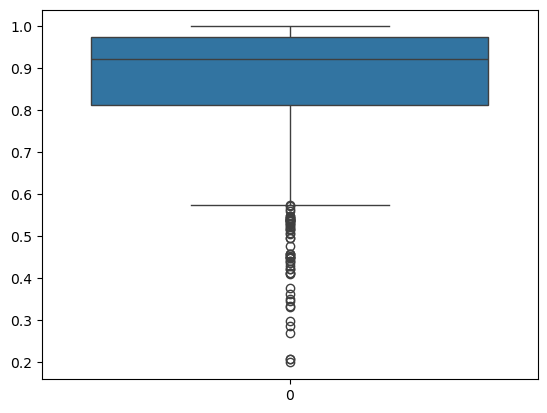

In [45]:
#Evaluation on test set
from scipy.stats import pearsonr

# Collect predictions
patch_probabilities = []
patch_IDs = []
final_predictions = []
true_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for features, labels, patch_ids in mil_loader_test:        
        
        # Get patch probabilities (since each bag has size 1)
        patch_predictions = model(features.squeeze(0))  # Remove extra dimension
        
        # Collect patch probabilities for the current slide
        patch_probabilities.append(patch_predictions.numpy())
        patch_IDs.append(patch_ids)
        
        # Aggregate to get the final prediction (mean of patch probabilities)
        final_prediction = patch_predictions.mean().item()
        final_predictions.append(final_prediction)  # Store the final prediction
        true_labels.append(labels.item())  # Store the true label

# Convert to numpy arrays for easier analysis
final_predictions = np.array(final_predictions)
true_labels = np.array(true_labels)

print("Final Predictions:", final_predictions)
print("True Labels:", true_labels)

test_mae = mean_absolute_error(true_labels, final_predictions)
print(f"Test Mean Absolute Error: {test_mae}")
test_mse = mean_squared_error(true_labels, final_predictions)
print(f"Test Mean Squared Error: {test_mse}")

test_nr = 2
sns.boxplot(data=patch_probabilities[test_nr])

# Compute Pearson correlation for the entire arrays
correlation, _ = pearsonr(true_labels, final_predictions)
print('Pearson correlation:', correlation)

Final Predictions: [0.77034009 0.8740983  0.8452884  0.77090633 0.77279752 0.83197147
 0.79384643 0.83673775 0.8160767  0.85341465 0.78709894 0.8145712
 0.78807884 0.81718445 0.74627155 0.87605208 0.85472703 0.74346501
 0.86675435 0.83668542 0.80040413 0.85863483 0.82095295 0.79683816
 0.88768381 0.86095864 0.81132448 0.83787769 0.7509191  0.75186467
 0.79319334 0.8528288  0.89590037 0.8349399  0.80467218 0.85641998
 0.79023284 0.7450031  0.85539073 0.88080001]


<Axes: >

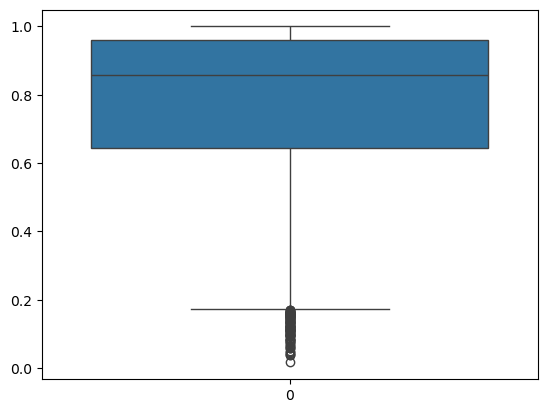

In [32]:
#Evaluation on orion dataset

patch_probabilities = []
patch_IDs = []
final_predictions = []
true_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for features, patch_ids in mil_loader_test_orion:        
        
        # Get patch probabilities (since each bag has size 1)
        patch_predictions = model(features.squeeze(0))  # Remove extra dimension
        
        # Collect patch probabilities for the current slide
        
        patch_probabilities.append(patch_predictions.numpy())
        patch_IDs.append(patch_ids)
        
        # Aggregate to get the final prediction (mean of patch probabilities)
        final_prediction = patch_predictions.mean().item()
        final_predictions.append(final_prediction)  # Store the final prediction
    
# Convert to numpy arrays for easier analysis
final_predictions = np.array(final_predictions)
print("Final Predictions:", final_predictions)

test_nr = 0
sns.boxplot(data=patch_probabilities[test_nr])


In [33]:
cell_type = 'tumor_purity'
dataframes = []
# Iterate through each sublist of tuples and corresponding probabilities
for tuples_list, probabilities in zip(patch_IDs, patch_probabilities):
    # Extract patch IDs from the tuples
    patch_ids = [tup[0] for tup in tuples_list]  # Extracting the first element of each tuple
    # Create a DataFrame for this set of patch IDs and probabilities\
    probabilities_flat = probabilities.ravel() 
    df = pd.DataFrame({
        'tile_ID': patch_ids,
        cell_type: probabilities_flat
    })
    # Append the DataFrame to the list
    dataframes.append(df)

# Concatenate all DataFrames into one big DataFrame
final_dataframe = pd.concat(dataframes, ignore_index=True)
final_dataframe['tile_ID'] = final_dataframe['tile_ID'].astype(str)

# Display the resulting DataFrame
print(final_dataframe)

#split_columns = final_dataframe['tile_ID'].str.split("_", 2, expand=True)
split_columns = final_dataframe['tile_ID'].str.rsplit("_", n=2, expand=True)

# Assign the new columns from the split results
final_dataframe['slide_id'] = split_columns[0]
final_dataframe['Coord_X'] = split_columns[1]
final_dataframe['Coord_Y'] = split_columns[2]

print(final_dataframe)

full_output_dir = "/home/evos/Outputs/CRC/Orion/3_tile_level_predictions_MIL"
final_dataframe.to_csv(f"{full_output_dir}/test.csv", sep="\t", index=False)

                                                  tile_ID  tumor_purity
0       18459_LSP10353_US_SCAN_OR_001__093059-register...      0.964954
1       18459_LSP10353_US_SCAN_OR_001__093059-register...      0.869290
2       18459_LSP10353_US_SCAN_OR_001__093059-register...      0.943940
3       18459_LSP10353_US_SCAN_OR_001__093059-register...      0.604964
4       18459_LSP10353_US_SCAN_OR_001__093059-register...      0.906459
...                                                   ...           ...
193605  19510_P37-S83_C40_US_SCAN_OR_001__163912-regis...      0.768413
193606  19510_P37-S83_C40_US_SCAN_OR_001__163912-regis...      0.997139
193607  19510_P37-S83_C40_US_SCAN_OR_001__163912-regis...      0.984734
193608  19510_P37-S83_C40_US_SCAN_OR_001__163912-regis...      0.813400
193609  19510_P37-S83_C40_US_SCAN_OR_001__163912-regis...      0.965582

[193610 rows x 2 columns]
                                                  tile_ID  tumor_purity  \
0       18459_LSP10353_US_SCAN_OR_